In [1]:
!mkdir TFModel

mkdir: cannot create directory ‘TFModel’: File exists


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/Face_Seg_0030.h5', compile=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 3)  0           ['normalization[0][0]']      

In [3]:
tf.keras.models.save_model(
    model,
    '/content/TFModel',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)


In [4]:
!zip -r /content/TFModel.zip /content/TFModel/*

updating: content/TFModel/assets/ (stored 0%)
updating: content/TFModel/keras_metadata.pb (deflated 95%)
updating: content/TFModel/saved_model.pb (deflated 91%)
updating: content/TFModel/variables/ (stored 0%)
updating: content/TFModel/variables/variables.index (deflated 76%)
updating: content/TFModel/variables/variables.data-00000-of-00001 (deflated 9%)


In [5]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/TFModel/') # path to the SavedModel directory
tflite_model = converter.convert()

In [6]:
with open('/content/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [11]:
input_details, output_details

([{'name': 'serving_default_input_1:0',
   'index': 0,
   'shape': array([  1, 512, 512,   3], dtype=int32),
   'shape_signature': array([ -1, 512, 512,   3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'StatefulPartitionedCall:0',
   'index': 434,
   'shape': array([  1, 512, 512,   1], dtype=int32),
   'shape_signature': array([ -1, 512, 512,   1], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

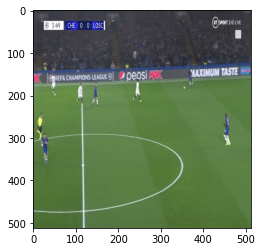

(1, 512, 512, 3)


In [12]:
# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = cv2.imread('/content/0afie3yx4nu3dlk.png')[:,:,::-1]
input_data = cv2.resize(input_data, (512, 512))
plt.imshow(input_data)
plt.show()
input_data = input_data / 255.0
input_data = input_data.astype(np.float32).reshape(1, 512, 512, 3)
print(input_data.shape)

interpreter.set_tensor(input_details[0]['index'], input_data)

In [13]:
interpreter.invoke()
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

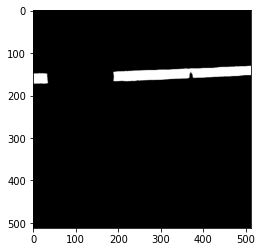

(1, 512, 512, 1)


In [14]:
plt.imshow(output_data.reshape(512, 512), cmap='gray')
plt.show()

print(output_data.shape)

1/1 [==============================] - 2s 2s/step


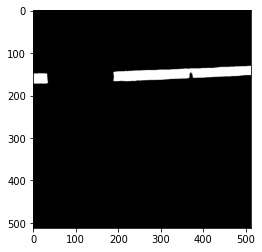

In [15]:
pred = model.predict(input_data)
plt.imshow(pred.reshape(512, 512), cmap='gray')
plt.show()